<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Nom, prénom
* Nom, prénom
* Nom, prénom

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un patient compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patients pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patients en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patients, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si le patient est décédé ou non pendant son séjour à l'hôpital. Heureusement, la plupart d'entre eux survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [38]:
import time
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [39]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

### Pourquoi la métrique utilisée ici est la *balanced accuracy* plutôt que simplement l'*accuracy* ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 2. Chargement les données

In [40]:
DATA = Path("public_data")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [41]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [42]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les télécharger sur Codalab et d'obtenir un score sur des données non-vues.

In [43]:
# Load testing set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [44]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Labels distribution

In [45]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

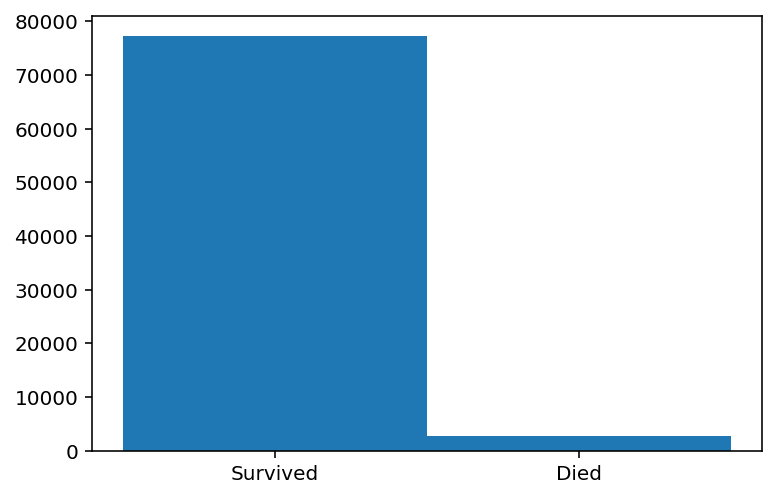

In [46]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

### Step 1 : datatypes / null values

In [47]:
# features datatype
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x_df.dtypes.value_counts())

int64      279
float64     51
object       7
dtype: int64


On remarque ici que certaines features sont de type "object", il va donc falloir les traiter lors du prepocessing afin de pouvoir les utiliser dans nos models.

In [48]:
# features that have null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x_df.isnull().any().value_counts())


False    331
True       6
dtype: int64


On remarque ici que certaines features ont des valeurs null pour certain labels, il va donc falloir ici aussi s'en occuper lors du preprocessing. Pour se rendre compte du nombre de null values dans notre dataset, on va afficher le nombre de valeur nulles pour chaque features.

In [49]:
# null values counter
for feature, counter in x_df.isnull().sum().items():
    if counter > 0:
        print(feature, ":", counter)

LANGUAGE : 1
MARITAL_STATUS : 1
ICU : 2
ECodes:Adverseeffectsofmedicalcare : 6
Otnutritdx : 2
Othnervdx : 1


On s'aperçoit que l'on a que très peut de valeurs null. Il est utile préférable de supprimer la feature du dataset si on a trop de valeurs null (ex : 70%) pour celle ci.  
Ici ça n'est pas le cas, ce qui est une bonne nouvelle pour la suite.

### Step 2 : Visualization

Exemple founis

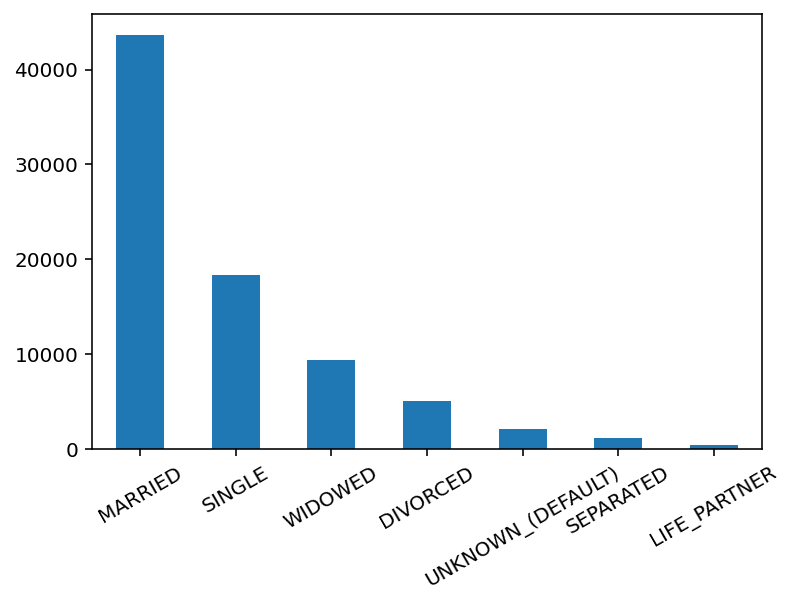

In [50]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

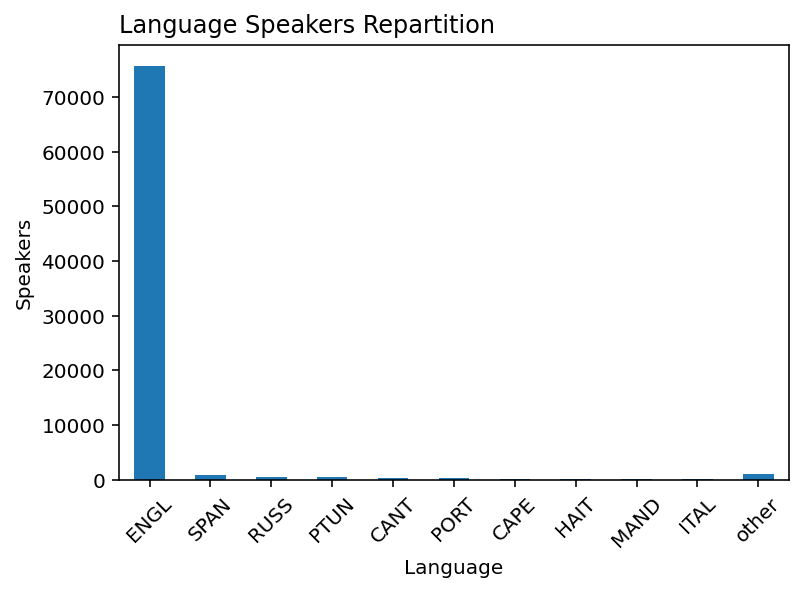

In [51]:
counts = x_df.LANGUAGE.value_counts()
threshold = 100
mask = counts > threshold
tail_counts = counts.loc[~mask].sum()
counts = counts.loc[mask]
counts['other'] = tail_counts
counts.plot(kind='bar')
plt.xticks(rotation=45)
plt.title("Language Speakers Repartition", loc='left')
plt.xlabel("Language")
plt.ylabel("Speakers")
plt.show()

#### Correlations

In [77]:
# TODO: Bar plot of the most correlated variables with y
dataset_df = x_df.copy()
dataset_df['DIED'] = ys
corr = dataset_df.corr()
corr_DIED = corr.DIED.drop('DIED')

<AxesSubplot:>

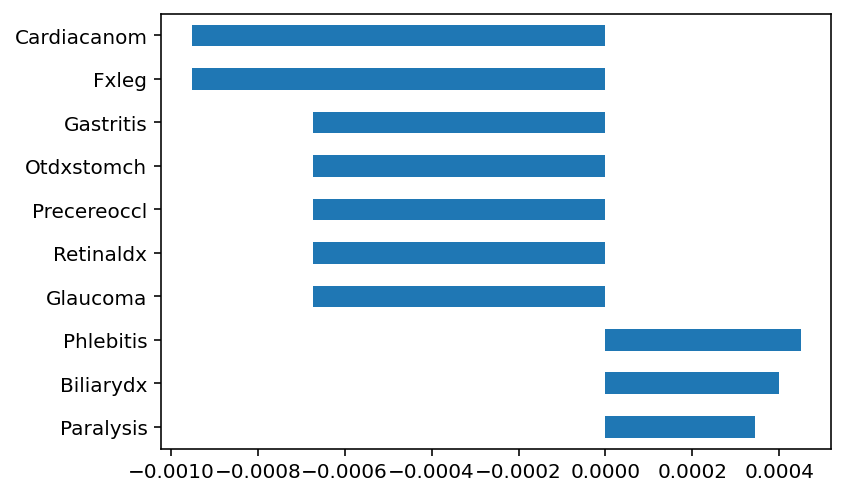

In [111]:
most_correlated = corr_DIED.reindex(corr_DIED.abs().sort_values().index)
most_correlated.head(10).plot(kind='barh')

Hint:

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

#### Autres graphiques

In [ ]:
# TODO: Add graph

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 4. Preprocessing

### Code : Traitement du problème des valeurs manquantes (ou non-définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Notez qu'il faut supprimer l'union des colonnes en question pour l'ensemble d'entrainement et de test, afin de garder des dimensions cohérentes.

In [30]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [31]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [32]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [33]:
na_cols = set(x_df.columns[x_df.isna().any()]) | set(
    x_test_df.columns[x_test_df.isna().any()]
)
na_cols

{'ECodes:Adverseeffectsofmedicalcare',
 'ICU',
 'LANGUAGE',
 'MARITAL_STATUS',
 'Othnervdx',
 'Otnutritdx'}

In [34]:
x_df.drop(columns=na_cols, inplace=True)
x_test_df.drop(columns=na_cols, inplace=True)

In [35]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [36]:
print(x_df.shape, x_test_df.shape)

(79999, 331) (20001, 331)


Proposez d'autre(s) stratégie(s) pour traiter le problème des NAN.

**Méthode n°1 : drop les labels**

In [ ]:
# TODO: other handling of NAN to replace the preciding column drop

### Domain Expertise

Simplifier les données pour notamment regrouper les catégories rares.

In [ ]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

#### Code : Effectuez des regrouppements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: other handling of NAN

### Transformation des données catégorielles en nombres entiers en utilisant deux type d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre la catégories de valeurs proches.

In [ ]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [ ]:
x_df.head(3)

In [ ]:
print(x_df.shape, ys.shape)

In [ ]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [ ]:
x_fact_df.head(3)

In [ ]:
x_test_fact_df.head(3)

### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code.

In [ ]:
codes, uniques = pd.factorize(x_df["RELIGION"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [ ]:
x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df[: len(x_df)]
x_test_1hot_df = x_all_1hot_df[len(x_df) :]

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

### Création de l'ensemble de validation

In [ ]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

#### PCA

Testez la PCA pour réduire le nombre de dimensions et voir si cela améliore le résultat.

Avant d'appliquer la PCA, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [52]:
# TODO: PCA

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Plot

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [ ]:
SCORINGS = "balanced_accuracy"

In [ ]:
# model = linear_model.LogisticRegression(max_iter=10000)
model = ensemble.RandomForestClassifier(n_estimators=10)

model.fit(x_train, y_train)  # training

## 6. Évaluations

In [ ]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
y_valid.value_counts()

### Code : Cross-Validation

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyper-paramètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de Cross-Validation (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [ ]:
CV = 10

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Cross-Validation

**Pour au moins 2 modèles (autres que les baselines) :**

* Donnez les résultats de la cross-validation ou du grid search sous forme de Boxplot (ou de diagramme à bâtons) pour:

    * La précision
    
    * Le rappel
    
    * Le f1-score
    
    * La `balanced_accuracy`


* Réalisez la matrice de confusion sur les prédictions (binaires) et décrivez la succinctement 

* Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Boxplot ou Barplot

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

In [ ]:
# TODO: Confusion Mtx

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

In [7]:
# TODO: ROC

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir slides du cours 6). Une des méthodes de génération est implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipe` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [8]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

NameError: name 'imblearn' is not defined

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


predictions_file = "mimic_synthetic_test.csv"

pd.Series(predictions).to_csv(predictions_file, index=False, header=False)

print("Predictions saved.")

t_stamp = time.asctime().replace(" ", "_").replace(":", "-")

output_file = f"submission_{t_stamp}.zip"

!zip test_submission.zip mimic_synthetic_test.csv  # create a ZIP

with ZipFile(output_file, "w") as z:
    z.write(predictions_file)

print(f"The submission is ready: {output_file}")

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patients en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un **Wasserstein GAN**.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---